In [1]:
import torch
import math

print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [2]:
torch.device('mps')

device(type='mps')

In [3]:
# device = 'mps' if torch.cuda.is_available() else 'cpu'
# device
torch.arange(1,10, device='mps')

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9], device='mps:0')

In [4]:
from torch import nn

In [5]:
from d2l_common import Module


class LSTMScratch(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        def triple(): return (init_weight(num_inputs, num_hiddens), init_weight(
            num_hiddens, num_hiddens), nn.Parameter(torch.zeros(num_hiddens)))

        self.W_xi, self.W_hi, self.b_i = triple()  # input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input gate

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),device=inputs.device)
        else:
            H,C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(X@self.W_xi+H@self.W_hi+self.b_i)
            F = torch.sigmoid(X@self.W_xf+H@self.W_hf+self.b_f)
            O = torch.sigmoid(X@self.W_xo+H@self.W_ho+self.b_o)
            C_tilde = torch.tanh(X@self.W_xc+H@self.W_hc+self.b_c)
            C = F*C + I*C_tilde
            H = O*torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)
        


In [11]:
from d2l_common import TimeMachine, RNNLMScratch, Trainer

data = TimeMachine(batch_size=1024, num_steps=32, device='mps')
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(lstm, len(data.vocab)).to('mps')
trainer = Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

complete 0 epoch train_loss=3.96087908744812 validate_loss=3.960878849029541
complete 1 epoch train_loss=3.960878849029541 validate_loss=3.960878849029541
complete 2 epoch train_loss=3.960878849029541 validate_loss=3.960878610610962
complete 3 epoch train_loss=3.960878610610962 validate_loss=3.960878610610962
complete 4 epoch train_loss=3.960878610610962 validate_loss=3.960878610610962
complete 5 epoch train_loss=3.960878610610962 validate_loss=3.960878372192383
complete 6 epoch train_loss=3.960878372192383 validate_loss=3.9608781337738037
complete 7 epoch train_loss=3.9608781337738037 validate_loss=3.9608781337738037
complete 8 epoch train_loss=3.9608781337738037 validate_loss=3.9608781337738037
complete 9 epoch train_loss=3.9608781337738037 validate_loss=3.9608778953552246
complete 10 epoch train_loss=3.9608778953552246 validate_loss=3.9608778953552246
complete 11 epoch train_loss=3.9608778953552246 validate_loss=3.9608776569366455
complete 12 epoch train_loss=3.9608776569366455 vali

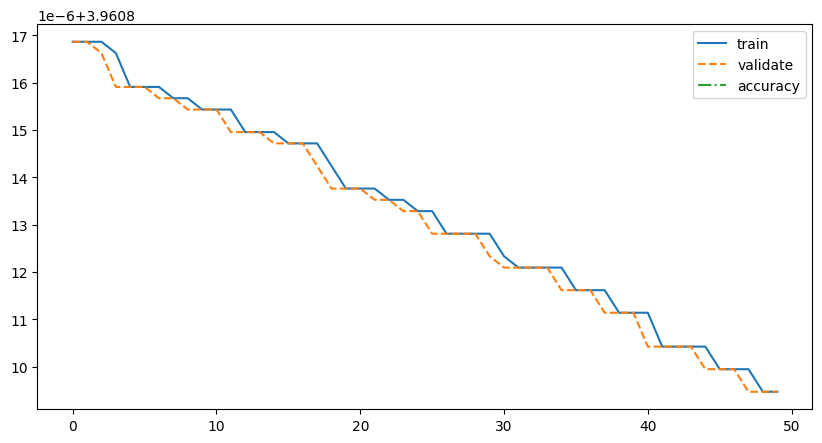

In [8]:
trainer.plot()

In [10]:
model.predict('it has', 20, data.vocab, device='mps')

'it hasaaaaaaaaaaaaaaaaaaaa'